In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, expr, when, col, max as spark_max
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, LinearSVC, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np
import time
import matplotlib.pyplot as plt
spark = SparkSession.builder.appName('FlightsProject').config("spark.executor.memory", "4g").config("spark.driver.memory", "4g").getOrCreate()

### Utils functions

In [2]:
def evaluate_models(models, test_df, labelCol='label'):
    evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol=labelCol)
    bin_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol=labelCol)

    metrics = {'Algorithm': [], 'Accuracy': [], 'ROC_AUC': [], 'PR_AUC': [], 'TP Rate': [], 'TN Rate': []}

    for name, model in models:
        pred = model.transform(test_df)

        roc = bin_eval.evaluate(pred, {bin_eval.metricName: "areaUnderROC"})
        auPR = bin_eval.evaluate(pred, {bin_eval.metricName: "areaUnderPR"})
        accuracy = evaluator.evaluate(pred, {evaluator.metricName: "accuracy"})
        tpByLabel = evaluator.evaluate(pred, {evaluator.metricName: "truePositiveRateByLabel", evaluator.metricLabel: 1.0})
        tnByLabel = evaluator.evaluate(pred, {evaluator.metricName: "truePositiveRateByLabel", evaluator.metricLabel: 0.0})

        metrics['Algorithm'].append(name)
        metrics['Accuracy'].append(accuracy)
        metrics['ROC_AUC'].append(roc)
        metrics['PR_AUC'].append(auPR)
        metrics['TP Rate'].append(tpByLabel)
        metrics['TN Rate'].append(tnByLabel)

    return metrics

In [3]:
def plot_results(metrics):
   
    # Plot evaluation metrics
    fig_metrics, ax_metrics = plt.subplots(figsize=(10, 5))

    metric_names = ['Accuracy', 'ROC_AUC', 'PR_AUC', 'TP Rate', 'TN Rate']
    x_metrics = np.arange(len(metric_names))  # The label locations
    width_metrics = 0.25  # The width of the bars

    for name in metrics['Algorithm']:
        offset = (metrics['Algorithm'].index(name) - len(metrics['Algorithm']) / 2) * width_metrics + width_metrics / 2
        alg_scores = [metrics[metric][metrics['Algorithm'].index(name)] for metric in metric_names]
        ax_metrics.bar(x_metrics + offset, alg_scores, width_metrics, label=name)

    ax_metrics.set_xlabel('Metric')
    ax_metrics.set_ylabel('Score')
    ax_metrics.set_title('Algorithm Performance Across Metrics')
    ax_metrics.set_xticks(x_metrics)
    ax_metrics.set_xticklabels(metric_names)
    ax_metrics.legend(title='Algorithm', loc='center left', bbox_to_anchor=(1, 0.5))
    ax_metrics.grid(axis='y')

    plt.tight_layout()
    plt.show()

### Process & prepare weather dataset. 

For a specific day & airport get max severity for the following events: fog, storm, snow and rain.

In [4]:
weather_data = spark.read.csv("flights_data/weather_data.csv", header=True, inferSchema=True)

In [5]:
weather_data = weather_data.withColumn('StartDate', split(weather_data['StartTime(UTC)'], ' ')[0])

columns = ['StartDate', 'AirportCode', 'Type', 'Severity']
weather_data = weather_data.select(*columns)

weather_data = weather_data.withColumn('AirportCode', expr("substring(AirportCode, 2, length(AirportCode))"))
weather_data = weather_data.filter(weather_data.StartDate.like('%2021%'))

In [6]:
severity_mapping = {"Other": 0, "UNK": 0, "Light": 1, "Moderate": 1, "Heavy": 2, "Severe": 2}

# Map Severity to SeverityValue using the mapping above
weather_data = weather_data.withColumn("SeverityValue", 
                                       when(col("Severity") == "Other", 0).when(col("Severity") == "UNK", 0) 
                                       .when(col("Severity") == "Light", 1).when(col("Severity") == "Moderate", 1) 
                                       .when(col("Severity") == "Heavy", 2).when(col("Severity") == "Severe", 2))

# Group data by day & airport & type to get max SeverityValue for each type of event
weather_data = weather_data.groupBy("StartDate", "AirportCode", "Type").agg(spark_max("SeverityValue").alias("MaxSeverity"))

# Group data by day & airport and create columns for events "Fog", "Storm", "Snow" and "Rain" which will hold the max severity value.
weather_data = weather_data.groupBy("StartDate", "AirportCode").pivot("Type", ["Fog", "Storm", "Snow", "Rain"]).agg(spark_max("MaxSeverity"))

# Fill missing value with 0 representing none/unknown
weather_data = weather_data.fillna(0)

# Rename columns for clarity
weather_data = weather_data.withColumnRenamed("Fog", "FogSeverity").withColumnRenamed("Storm", "StormSeverity") \
               .withColumnRenamed("Snow", "SnowSeverity").withColumnRenamed("Rain", "RainSeverity")

weather_data.show(3)

+----------+-----------+-----------+-------------+------------+------------+
| StartDate|AirportCode|FogSeverity|StormSeverity|SnowSeverity|RainSeverity|
+----------+-----------+-----------+-------------+------------+------------+
|2021-06-02|        NUQ|          2|            0|           0|           0|
|2021-08-02|        AMA|          2|            0|           0|           0|
|2021-02-19|        BLM|          2|            0|           1|           1|
+----------+-----------+-----------+-------------+------------+------------+
only showing top 3 rows



### Prepare & Process flights dataset
Read flights dataset, keep relevant columns and join with weather dataset. Drop null values and transform categorical attributes to numerical attributes.

In [7]:
data = spark.read.csv("flights_data/cflights2021.csv", header=True, inferSchema=True)
columns = ['DayofMonth', 'Month', 'FlightDate', 'Origin', 'Dest', 'DepTime', 'Distance', 'AirTime', 'TaxiIn', 'TaxiOut', 'ArrDel15']
data = data.select(*columns)
data.show(3)

+----------+-----+----------+------+----+-------+--------+-------+------+-------+--------+
|DayofMonth|Month|FlightDate|Origin|Dest|DepTime|Distance|AirTime|TaxiIn|TaxiOut|ArrDel15|
+----------+-----+----------+------+----+-------+--------+-------+------+-------+--------+
|         3|    3|2021-03-03|   SGU| PHX|  714.0|   262.0|   49.0|   5.0|   10.0|     0.0|
|         3|    3|2021-03-03|   PHX| SGU|  917.0|   262.0|   48.0|   3.0|   23.0|     0.0|
|         3|    3|2021-03-03|   MHT| ORD| 1321.0|   843.0|  129.0|  16.0|   15.0|     0.0|
+----------+-----+----------+------+----+-------+--------+-------+------+-------+--------+
only showing top 3 rows



In [8]:
# Join flights and weather data
data = data.join(weather_data, (data.FlightDate == weather_data.StartDate) & (data.Origin == weather_data.AirportCode), how="left")

# Fill missing value with 0 representing none/unknown
data = data.fillna({"FogSeverity": 0, "StormSeverity": 0, "SnowSeverity": 0, "RainSeverity": 0})

columns = ['DayofMonth', 'Month', 'Origin', 'Dest', 'DepTime', 'Distance', 'AirTime', 'TaxiIn', 'TaxiOut', 'FogSeverity', 
           'StormSeverity', 'SnowSeverity', 'RainSeverity', 'ArrDel15']
data = data.select(*columns)
data.show(3)

+----------+-----+------+----+-------+--------+-------+------+-------+-----------+-------------+------------+------------+--------+
|DayofMonth|Month|Origin|Dest|DepTime|Distance|AirTime|TaxiIn|TaxiOut|FogSeverity|StormSeverity|SnowSeverity|RainSeverity|ArrDel15|
+----------+-----+------+----+-------+--------+-------+------+-------+-----------+-------------+------------+------------+--------+
|        18|    3|   DFW| ORD| 1242.0|   801.0|  113.0|   7.0|   19.0|          0|            0|           0|           0|     0.0|
|        19|    5|   HOU| SJU| 1110.0|  1997.0|  236.0|   6.0|   20.0|          0|            0|           0|           1|     0.0|
|        19|    5|   HOU| SLC| 1049.0|  1214.0|  156.0|   4.0|   30.0|          0|            0|           0|           1|     0.0|
+----------+-----+------+----+-------+--------+-------+------+-------+-----------+-------------+------------+------------+--------+
only showing top 3 rows



In [9]:
# Drop rows with null values
data = data.na.drop()

In [10]:
# Unpersist weather data, no longer needed
weather_data.unpersist()

DataFrame[StartDate: string, AirportCode: string, FogSeverity: int, StormSeverity: int, SnowSeverity: int, RainSeverity: int]

In [11]:
si = StringIndexer(inputCol='Origin', outputCol='OriginEnc')
si_fit = si.fit(data)
si2 = StringIndexer(inputCol='Dest', outputCol='DestEnc')
si2_fit = si2.fit(data)

data = si_fit.transform(data)
data = si2_fit.transform(data)
columns = ['DayofMonth', 'Month', 'OriginEnc', 'DestEnc', 'DepTime', 'Distance', 'AirTime', 'TaxiIn', 'TaxiOut', 'FogSeverity', 
           'StormSeverity', 'SnowSeverity', 'RainSeverity', 'ArrDel15']
data = data.select(*columns)
data.show(3)

+----------+-----+---------+-------+-------+--------+-------+------+-------+-----------+-------------+------------+------------+--------+
|DayofMonth|Month|OriginEnc|DestEnc|DepTime|Distance|AirTime|TaxiIn|TaxiOut|FogSeverity|StormSeverity|SnowSeverity|RainSeverity|ArrDel15|
+----------+-----+---------+-------+-------+--------+-------+------+-------+-----------+-------------+------------+------------+--------+
|         1|    1|    152.0|    0.0|  813.0|   143.0|   39.0|   7.0|   10.0|          2|            0|           0|           1|     0.0|
|         1|    1|    152.0|    0.0| 1253.0|   143.0|   33.0|  18.0|   18.0|          2|            0|           0|           1|     0.0|
|         1|    1|    152.0|    0.0| 1710.0|   143.0|   32.0|   8.0|    7.0|          2|            0|           0|           1|     0.0|
+----------+-----+---------+-------+-------+--------+-------+------+-------+-----------+-------------+------------+------------+--------+
only showing top 3 rows



### Models training & evaluation
Create Logistic Regression, Desicion Tree and Support Vector Machine classifiers and evaluate them.

In [12]:
inputCols=['DayofMonth', 'Month', 'OriginEnc', 'DestEnc', 'DepTime', 'Distance', 'AirTime', 'TaxiIn', 'TaxiOut', 'FogSeverity', 
           'StormSeverity', 'SnowSeverity', 'RainSeverity']
assembler_index = VectorAssembler(inputCols=inputCols, outputCol='features')
data = assembler_index.transform(data)

In [13]:
# Split data: 70% training, 30% testing
train_data, test_data = data.randomSplit([0.7, 0.3], seed=12345)

In [14]:
start = time.time()
lr = LogisticRegression(featuresCol='features', labelCol='ArrDel15')
lr_model = lr.fit(train_data)
end = time.time()
print(f"Time for LR model training: {end-start} seconds")

Time for LR model training: 62.49591064453125 seconds


In [15]:
start = time.time()
dtc = DecisionTreeClassifier(labelCol='ArrDel15', seed=42, maxDepth=15, maxBins=400)
dtc_model = dtc.fit(train_data)
end = time.time()
print(f"Time for DT model training: {end-start} seconds")

Time for DT model training: 67.55614185333252 seconds


In [16]:
start = time.time()
svm = LinearSVC(labelCol="ArrDel15", featuresCol="features", maxIter=10, regParam=0.1)
svm_model = svm.fit(train_data)
end = time.time()
print(f"Time for SVM model training: {end-start} seconds")

Time for SVM model training: 59.88911557197571 seconds


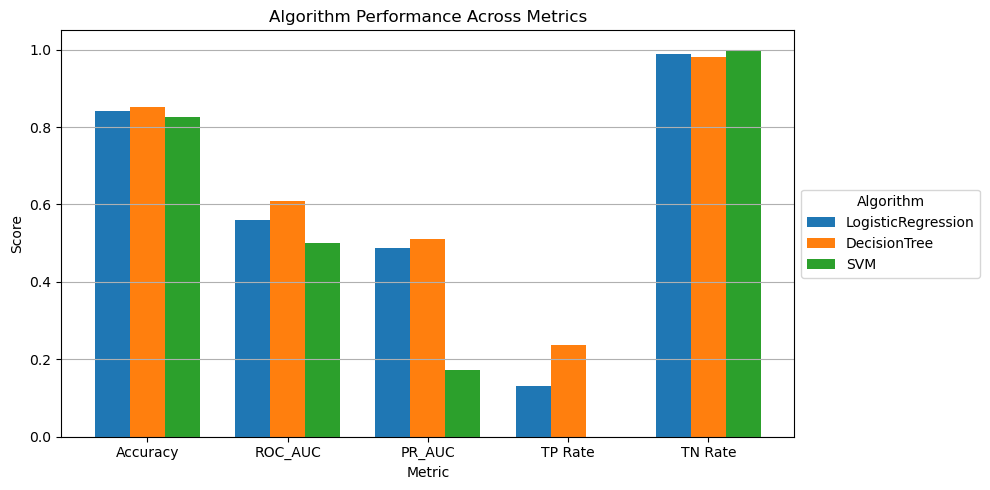

{'Algorithm': ['LogisticRegression', 'DecisionTree', 'SVM'], 'Accuracy': [0.8413865783918509, 0.8520448572269079, 0.8271060364586196], 'ROC_AUC': [0.5609016845274937, 0.6090948056595109, 0.5], 'PR_AUC': [0.4867047675270756, 0.5100839529751089, 0.17289396354138042], 'TP Rate': [0.13216472677978777, 0.2377319684008788, 0.0], 'TN Rate': [0.9896386422751994, 0.980457642918143, 1.0]}


In [17]:
models = [("LogisticRegression", lr_model), ("DecisionTree", dtc_model), ("SVM", svm_model)]
metrics = evaluate_models(models, test_data, labelCol='ArrDel15')
plot_results(metrics)
print(metrics)

In [22]:
dtc1 = DecisionTreeClassifier(labelCol='ArrDel15', seed=42, maxDepth=5, maxBins=400)
dtc_model1 = dtc1.fit(train_data)

dtc2 = DecisionTreeClassifier(labelCol='ArrDel15', seed=42, maxDepth=10, maxBins=400)
dtc_model2 = dtc2.fit(train_data)

dtc3 = DecisionTreeClassifier(labelCol='ArrDel15', seed=42, maxDepth=15, maxBins=400)
dtc_model3 = dtc3.fit(train_data)

In [23]:
models = [("dtc5", dtc_model1), ("dtc10", dtc_model2), ("dtc15", dtc_model3)]
metrics = evaluate_models(models, test_data, labelCol='ArrDel15')
print(metrics)

{'Algorithm': ['dtc5', 'dtc10', 'dtc15'], 'Accuracy': [0.8421069362324369, 0.8473902787790231, 0.8520448572269079], 'ROC_AUC': [0.5587502699685251, 0.5941526280884617, 0.6090948056595109], 'PR_AUC': [0.5054320342639115, 0.4895949969843214, 0.5100839529751089], 'TP Rate': [0.12562364636407547, 0.20706461615170071, 0.2377319684008788], 'TN Rate': [0.9918768935729747, 0.9812406400252227, 0.980457642918143]}


In [24]:
dtc = DecisionTreeClassifier(labelCol='ArrDel15', seed=42, maxDepth=3, maxBins=400, impurity="entropy")
dtc_model = dtc1.fit(train_data)

dtc1 = DecisionTreeClassifier(labelCol='ArrDel15', seed=42, maxDepth=5, maxBins=400, impurity="entropy")
dtc_model1 = dtc1.fit(train_data)

dtc2 = DecisionTreeClassifier(labelCol='ArrDel15', seed=42, maxDepth=10, maxBins=400, impurity="entropy")
dtc_model2 = dtc2.fit(train_data)

dtc3 = DecisionTreeClassifier(labelCol='ArrDel15', seed=42, maxDepth=15, maxBins=400, impurity="entropy")
dtc_model3 = dtc3.fit(train_data)

In [25]:
models = [("dtc3", dtc_model), ("dtc5", dtc_model1), ("dtc10", dtc_model2), ("dtc15", dtc_model3)]
metrics = evaluate_models(models, test_data, labelCol='ArrDel15')
print(metrics)

{'Algorithm': ['dtc3', 'dtc5', 'dtc10', 'dtc15'], 'Accuracy': [0.8421069362324369, 0.8423520841886573, 0.8469802620874106, 0.8518045583511402], 'ROC_AUC': [0.5587502699685251, 0.5624799255412023, 0.5922964367228345, 0.6078193968831351], 'PR_AUC': [0.5054320342639115, 0.49654002110334494, 0.4884309732878377, 0.5097718126850566], 'TP Rate': [0.12562364636407547, 0.13467956808301781, 0.20299786534536218, 0.23487433584194206], 'TN Rate': [0.9918768935729747, 0.990280282999387, 0.981595008100307, 0.9807644579243281]}
